# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

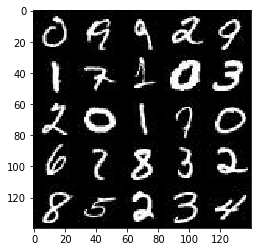

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

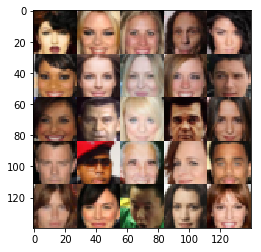

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width,image_height,image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, (None), name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/home/carnd/anaconda3/envs/dl/lib/python3.5/runpy.py", line 184, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/home/carnd/anaconda3/envs/dl/lib/python3.5/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>\n    app.launch_new_instance()', 'File "/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start\n    ioloop.IOLoop.instance().start()', 'File "/home/carnd/anaconda3/envs/dl/

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    n_units=128
    #ADDED BY REVIEW
    alpha = 0.10
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        print("images.get_shape()",images.get_shape())
        x1 = tf.layers.conv2d(images, 32, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x32
        
        x2 = tf.layers.conv2d(relu1, 64, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x64
        
        x3 = tf.layers.conv2d(relu1, 128, 5, strides=1, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 7x7x128
        
        x4 = tf.layers.conv2d(relu3, 256, 5, strides=1, padding='same')
        bn4 = tf.layers.batch_normalization(x4, training=True)
        relu4 = tf.maximum(alpha * bn4, bn4)
        # 7x7x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits 
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

images.get_shape() (?, 28, 28, 3)
images.get_shape() (?, 28, 28, 3)
Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    n_units=128
    alpha = 0.10
    
    
    with tf.variable_scope('generator', reuse=(not is_train)):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training= is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512 now
        
        #SUGGESTED 256= 2x128
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x128 now
        
        #SUGGESTED 128= 2x64
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training= is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 28x28x64 now
        
        #SUGGESTED 128= 2x64
        x4 = tf.layers.conv2d_transpose(x3, 32, 5, strides=1, padding='same')
        x4 = tf.layers.batch_normalization(x4, training= is_train)
        x4 = tf.maximum(alpha * x4, x4)
        # 28x28x32 now
        
        # Output layer
        print("out_channel_dim",out_channel_dim)
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim,3, strides=1, padding='same')
        #ADDED BY REVIEW
        #logits = tf.layers.batch_normalization(logits, training= is_train)
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

out_channel_dim 5
out_channel_dim 5
Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    #alpha = 0.01
    # ADDED BY REVIEW Smoothing 
    smooth = 0.1
    
    g_model = generator(input_z, out_channel_dim)
   
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=(tf.ones_like(d_model_real)*(1 - smooth))))
  
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
   
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    
    
    
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

out_channel_dim 4
images.get_shape() (?, 28, 28, 4)
images.get_shape() (?, 28, 28, 4)
Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt
   


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, is_train=False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    print ("data_shape ",data_shape)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    steps = 0
    print_every=10
    show_every=100
    samples, losses = [], []
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_images = batch_images * 2.0

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                # ?????
                #_ = sess.run(g_opt, feed_dict={input_z: batch_z})
                #ADDED BY REVIEW: 2 times generator optimization
               # _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format( epoch_i+1,epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                #if steps % show_every == 0:
                #    gen_samples = sess.run(
                       
                #                   generator(input_z, data_shape[3], is_train=False),
                #                   feed_dict={input_z: sample_z})
                #    samples.append(gen_samples)
                #    _ = view_samples(-1, samples, 6, 12, figsize=figsize)
                #    plt.show()
                
                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                    
        saver.save(sess, './checkpoints/generator.ckpt')

   
    
             

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

mnist_dataset.shape:  (60000, 28, 28, 1)
data_shape  (60000, 28, 28, 1)
out_channel_dim 1
images.get_shape() (?, 28, 28, 1)
images.get_shape() (?, 28, 28, 1)
Epoch 1/2... Discriminator Loss: 0.4656... Generator Loss: 2.3851
Epoch 1/2... Discriminator Loss: 0.6468... Generator Loss: 1.5205
Epoch 1/2... Discriminator Loss: 0.6047... Generator Loss: 1.7432
Epoch 1/2... Discriminator Loss: 0.7285... Generator Loss: 2.3906
Epoch 1/2... Discriminator Loss: 1.1642... Generator Loss: 0.7759
Epoch 1/2... Discriminator Loss: 0.7052... Generator Loss: 1.5288
Epoch 1/2... Discriminator Loss: 1.5324... Generator Loss: 0.7704
Epoch 1/2... Discriminator Loss: 1.5838... Generator Loss: 0.4785
Epoch 1/2... Discriminator Loss: 1.4547... Generator Loss: 0.6731
Epoch 1/2... Discriminator Loss: 1.4888... Generator Loss: 0.6903
out_channel_dim 1


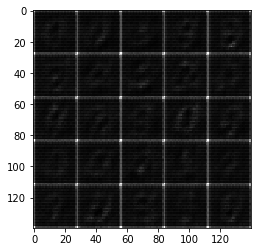

Epoch 1/2... Discriminator Loss: 1.5802... Generator Loss: 0.7832
Epoch 1/2... Discriminator Loss: 1.5753... Generator Loss: 0.8864
Epoch 1/2... Discriminator Loss: 1.4147... Generator Loss: 0.5693
Epoch 1/2... Discriminator Loss: 1.4169... Generator Loss: 0.5628
Epoch 1/2... Discriminator Loss: 1.3885... Generator Loss: 0.6472
Epoch 1/2... Discriminator Loss: 1.4595... Generator Loss: 0.5168
Epoch 1/2... Discriminator Loss: 1.4059... Generator Loss: 0.5780
Epoch 1/2... Discriminator Loss: 1.3647... Generator Loss: 0.6755
Epoch 1/2... Discriminator Loss: 1.3891... Generator Loss: 0.5690
Epoch 1/2... Discriminator Loss: 1.2918... Generator Loss: 0.7066
out_channel_dim 1


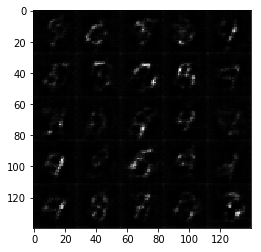

Epoch 1/2... Discriminator Loss: 1.4537... Generator Loss: 0.4761
Epoch 1/2... Discriminator Loss: 1.3188... Generator Loss: 0.6424
Epoch 1/2... Discriminator Loss: 1.3159... Generator Loss: 0.6374
Epoch 1/2... Discriminator Loss: 1.2981... Generator Loss: 0.6223
Epoch 1/2... Discriminator Loss: 1.2835... Generator Loss: 0.7350
Epoch 1/2... Discriminator Loss: 1.2761... Generator Loss: 0.7064
Epoch 1/2... Discriminator Loss: 1.3395... Generator Loss: 0.5784
Epoch 1/2... Discriminator Loss: 1.3989... Generator Loss: 0.5303
Epoch 1/2... Discriminator Loss: 1.2086... Generator Loss: 0.8661
Epoch 1/2... Discriminator Loss: 1.3003... Generator Loss: 1.2679
out_channel_dim 1


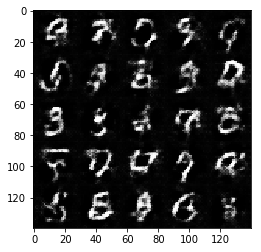

Epoch 1/2... Discriminator Loss: 1.2826... Generator Loss: 1.0296
Epoch 1/2... Discriminator Loss: 1.3229... Generator Loss: 1.2354
Epoch 1/2... Discriminator Loss: 1.4066... Generator Loss: 0.5528
Epoch 1/2... Discriminator Loss: 1.5464... Generator Loss: 0.4277
Epoch 1/2... Discriminator Loss: 1.3191... Generator Loss: 0.7105
Epoch 1/2... Discriminator Loss: 1.4554... Generator Loss: 0.4967
Epoch 1/2... Discriminator Loss: 1.2798... Generator Loss: 0.7198
Epoch 1/2... Discriminator Loss: 1.3951... Generator Loss: 0.6061
Epoch 1/2... Discriminator Loss: 1.3404... Generator Loss: 0.6950
Epoch 1/2... Discriminator Loss: 1.4503... Generator Loss: 0.5158
out_channel_dim 1


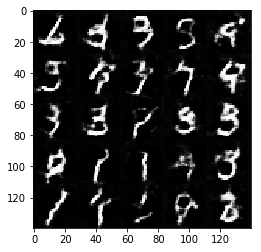

Epoch 1/2... Discriminator Loss: 1.3903... Generator Loss: 0.6312
Epoch 1/2... Discriminator Loss: 1.5422... Generator Loss: 0.4292
Epoch 1/2... Discriminator Loss: 1.3296... Generator Loss: 0.7198
Epoch 1/2... Discriminator Loss: 1.3365... Generator Loss: 0.9800
Epoch 1/2... Discriminator Loss: 1.4541... Generator Loss: 1.2517
Epoch 1/2... Discriminator Loss: 1.3769... Generator Loss: 1.1640
Epoch 2/2... Discriminator Loss: 1.3434... Generator Loss: 1.1357
Epoch 2/2... Discriminator Loss: 1.2927... Generator Loss: 0.9911
Epoch 2/2... Discriminator Loss: 1.3936... Generator Loss: 1.2529
Epoch 2/2... Discriminator Loss: 1.3805... Generator Loss: 1.2337
out_channel_dim 1


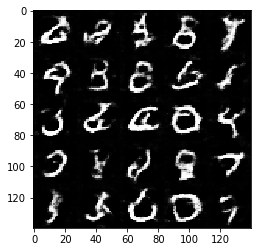

Epoch 2/2... Discriminator Loss: 1.3097... Generator Loss: 0.9212
Epoch 2/2... Discriminator Loss: 1.4660... Generator Loss: 1.2458
Epoch 2/2... Discriminator Loss: 1.3127... Generator Loss: 1.0782
Epoch 2/2... Discriminator Loss: 1.3620... Generator Loss: 1.0280
Epoch 2/2... Discriminator Loss: 1.2617... Generator Loss: 0.7656
Epoch 2/2... Discriminator Loss: 1.4195... Generator Loss: 0.5386
Epoch 2/2... Discriminator Loss: 1.3537... Generator Loss: 0.6456
Epoch 2/2... Discriminator Loss: 1.4537... Generator Loss: 0.5020
Epoch 2/2... Discriminator Loss: 1.3512... Generator Loss: 0.6362
Epoch 2/2... Discriminator Loss: 1.4217... Generator Loss: 0.5380
out_channel_dim 1


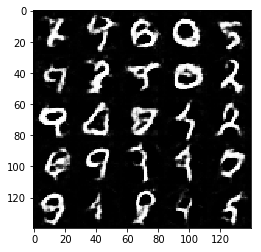

Epoch 2/2... Discriminator Loss: 1.3692... Generator Loss: 0.6263
Epoch 2/2... Discriminator Loss: 1.3762... Generator Loss: 0.6200
Epoch 2/2... Discriminator Loss: 1.3785... Generator Loss: 0.6043
Epoch 2/2... Discriminator Loss: 1.4385... Generator Loss: 0.4969
Epoch 2/2... Discriminator Loss: 1.2643... Generator Loss: 0.7675
Epoch 2/2... Discriminator Loss: 1.2885... Generator Loss: 0.6952
Epoch 2/2... Discriminator Loss: 1.4081... Generator Loss: 0.5580
Epoch 2/2... Discriminator Loss: 1.3350... Generator Loss: 0.6059
Epoch 2/2... Discriminator Loss: 1.3777... Generator Loss: 0.6064
Epoch 2/2... Discriminator Loss: 1.3400... Generator Loss: 0.6025
out_channel_dim 1


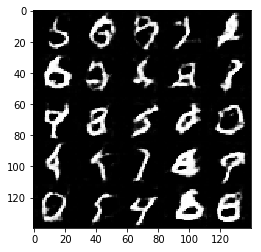

Epoch 2/2... Discriminator Loss: 1.3487... Generator Loss: 0.6675
Epoch 2/2... Discriminator Loss: 1.3476... Generator Loss: 0.6383
Epoch 2/2... Discriminator Loss: 1.3004... Generator Loss: 0.6934
Epoch 2/2... Discriminator Loss: 1.2825... Generator Loss: 0.7494
Epoch 2/2... Discriminator Loss: 1.2722... Generator Loss: 1.1310
Epoch 2/2... Discriminator Loss: 1.5494... Generator Loss: 1.4864
Epoch 2/2... Discriminator Loss: 1.3230... Generator Loss: 0.7191
Epoch 2/2... Discriminator Loss: 1.2720... Generator Loss: 0.9998
Epoch 2/2... Discriminator Loss: 1.3172... Generator Loss: 1.2091
Epoch 2/2... Discriminator Loss: 1.2526... Generator Loss: 1.2212
out_channel_dim 1


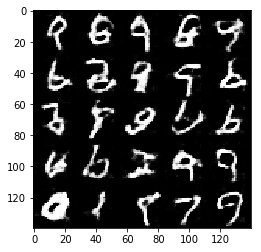

Epoch 2/2... Discriminator Loss: 1.3117... Generator Loss: 1.0891
Epoch 2/2... Discriminator Loss: 1.3527... Generator Loss: 1.1160
Epoch 2/2... Discriminator Loss: 1.2882... Generator Loss: 1.0356
Epoch 2/2... Discriminator Loss: 1.2646... Generator Loss: 0.8841
Epoch 2/2... Discriminator Loss: 1.3387... Generator Loss: 1.2214
Epoch 2/2... Discriminator Loss: 1.5126... Generator Loss: 1.8113
Epoch 2/2... Discriminator Loss: 1.3052... Generator Loss: 0.8604
Epoch 2/2... Discriminator Loss: 1.2983... Generator Loss: 0.8105
Epoch 2/2... Discriminator Loss: 1.3271... Generator Loss: 0.6713
Epoch 2/2... Discriminator Loss: 1.2722... Generator Loss: 0.7525
out_channel_dim 1


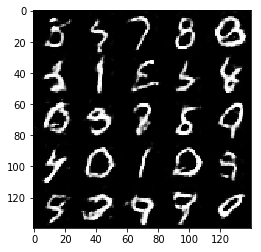

Epoch 2/2... Discriminator Loss: 1.3102... Generator Loss: 1.0518
Epoch 2/2... Discriminator Loss: 1.3914... Generator Loss: 1.2824
Epoch 2/2... Discriminator Loss: 1.2613... Generator Loss: 1.0610


In [12]:
#ADDED BY REVIEW (doubled)
batch_size = 128
z_dim = 100
learning_rate = 0.0003
beta1 = 0.4



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
print("mnist_dataset.shape: ", mnist_dataset.shape)
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

data_shape  (202599, 28, 28, 3)
out_channel_dim 3
images.get_shape() (?, 28, 28, 3)
images.get_shape() (?, 28, 28, 3)
Epoch 1/1... Discriminator Loss: 1.4151... Generator Loss: 0.6975
Epoch 1/1... Discriminator Loss: 1.4327... Generator Loss: 0.7195
Epoch 1/1... Discriminator Loss: 1.0541... Generator Loss: 1.0643
Epoch 1/1... Discriminator Loss: 0.7149... Generator Loss: 2.2568
Epoch 1/1... Discriminator Loss: 1.0258... Generator Loss: 1.3237
Epoch 1/1... Discriminator Loss: 1.2509... Generator Loss: 1.6633
Epoch 1/1... Discriminator Loss: 0.9566... Generator Loss: 1.4696
Epoch 1/1... Discriminator Loss: 0.8138... Generator Loss: 1.8324
Epoch 1/1... Discriminator Loss: 1.0866... Generator Loss: 2.0591
Epoch 1/1... Discriminator Loss: 0.7578... Generator Loss: 1.9015
out_channel_dim 3


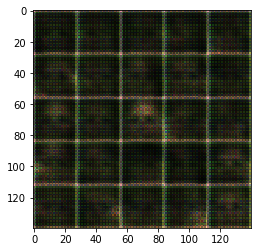

Epoch 1/1... Discriminator Loss: 0.8850... Generator Loss: 1.4426
Epoch 1/1... Discriminator Loss: 0.7108... Generator Loss: 2.9677
Epoch 1/1... Discriminator Loss: 0.7314... Generator Loss: 1.6073
Epoch 1/1... Discriminator Loss: 0.7011... Generator Loss: 1.9141
Epoch 1/1... Discriminator Loss: 0.8892... Generator Loss: 1.9100
Epoch 1/1... Discriminator Loss: 0.5618... Generator Loss: 2.0386
Epoch 1/1... Discriminator Loss: 1.0240... Generator Loss: 0.8718
Epoch 1/1... Discriminator Loss: 1.6135... Generator Loss: 0.3942
Epoch 1/1... Discriminator Loss: 0.8581... Generator Loss: 1.1161
Epoch 1/1... Discriminator Loss: 0.6066... Generator Loss: 2.3440
out_channel_dim 3


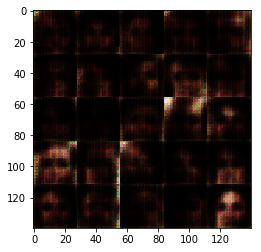

Epoch 1/1... Discriminator Loss: 0.6606... Generator Loss: 2.2879
Epoch 1/1... Discriminator Loss: 0.6035... Generator Loss: 1.9217
Epoch 1/1... Discriminator Loss: 1.1361... Generator Loss: 0.7206
Epoch 1/1... Discriminator Loss: 1.0079... Generator Loss: 3.2370
Epoch 1/1... Discriminator Loss: 1.5662... Generator Loss: 0.4302
Epoch 1/1... Discriminator Loss: 0.5861... Generator Loss: 2.0505
Epoch 1/1... Discriminator Loss: 0.5131... Generator Loss: 5.8078
Epoch 1/1... Discriminator Loss: 0.5186... Generator Loss: 3.1026
Epoch 1/1... Discriminator Loss: 0.5667... Generator Loss: 2.0445
Epoch 1/1... Discriminator Loss: 0.9464... Generator Loss: 0.9095
out_channel_dim 3


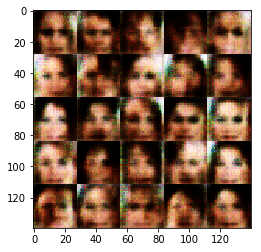

Epoch 1/1... Discriminator Loss: 0.5136... Generator Loss: 2.6596
Epoch 1/1... Discriminator Loss: 1.1502... Generator Loss: 0.6626
Epoch 1/1... Discriminator Loss: 0.8771... Generator Loss: 1.7082
Epoch 1/1... Discriminator Loss: 0.7620... Generator Loss: 1.3236
Epoch 1/1... Discriminator Loss: 0.7343... Generator Loss: 1.9074
Epoch 1/1... Discriminator Loss: 1.0103... Generator Loss: 1.0866
Epoch 1/1... Discriminator Loss: 1.2258... Generator Loss: 0.6729
Epoch 1/1... Discriminator Loss: 0.7045... Generator Loss: 2.9226
Epoch 1/1... Discriminator Loss: 0.5221... Generator Loss: 2.2714
Epoch 1/1... Discriminator Loss: 0.9687... Generator Loss: 1.2859
out_channel_dim 3


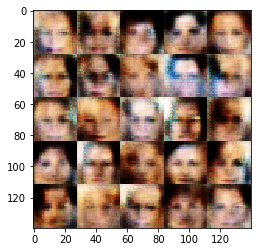

Epoch 1/1... Discriminator Loss: 1.4906... Generator Loss: 0.4593
Epoch 1/1... Discriminator Loss: 1.0175... Generator Loss: 1.2499
Epoch 1/1... Discriminator Loss: 1.4171... Generator Loss: 0.5411
Epoch 1/1... Discriminator Loss: 1.2800... Generator Loss: 0.7695
Epoch 1/1... Discriminator Loss: 1.1997... Generator Loss: 0.7806
Epoch 1/1... Discriminator Loss: 1.2413... Generator Loss: 1.1304
Epoch 1/1... Discriminator Loss: 0.8735... Generator Loss: 1.5515
Epoch 1/1... Discriminator Loss: 0.9414... Generator Loss: 1.2595
Epoch 1/1... Discriminator Loss: 1.0232... Generator Loss: 1.1439
Epoch 1/1... Discriminator Loss: 0.8537... Generator Loss: 1.2273
out_channel_dim 3


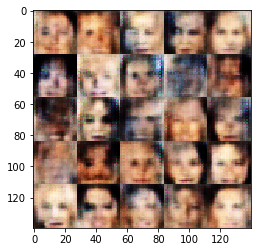

Epoch 1/1... Discriminator Loss: 0.5499... Generator Loss: 2.1562
Epoch 1/1... Discriminator Loss: 1.3658... Generator Loss: 0.7088
Epoch 1/1... Discriminator Loss: 1.2361... Generator Loss: 0.9962
Epoch 1/1... Discriminator Loss: 1.1909... Generator Loss: 0.9672
Epoch 1/1... Discriminator Loss: 0.9413... Generator Loss: 1.3820
Epoch 1/1... Discriminator Loss: 1.1973... Generator Loss: 0.7570
Epoch 1/1... Discriminator Loss: 1.2504... Generator Loss: 0.7709
Epoch 1/1... Discriminator Loss: 1.1988... Generator Loss: 0.8651
Epoch 1/1... Discriminator Loss: 1.2352... Generator Loss: 0.8609
Epoch 1/1... Discriminator Loss: 1.3652... Generator Loss: 0.8519
out_channel_dim 3


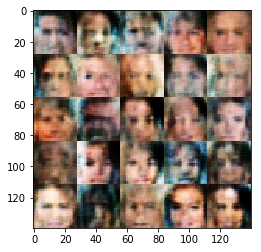

Epoch 1/1... Discriminator Loss: 1.2014... Generator Loss: 0.9381
Epoch 1/1... Discriminator Loss: 1.2673... Generator Loss: 0.7054
Epoch 1/1... Discriminator Loss: 0.9541... Generator Loss: 1.6769
Epoch 1/1... Discriminator Loss: 1.1467... Generator Loss: 1.0616
Epoch 1/1... Discriminator Loss: 1.1963... Generator Loss: 0.8090
Epoch 1/1... Discriminator Loss: 1.2688... Generator Loss: 1.0551
Epoch 1/1... Discriminator Loss: 1.3253... Generator Loss: 0.6304
Epoch 1/1... Discriminator Loss: 1.2096... Generator Loss: 0.7361
Epoch 1/1... Discriminator Loss: 1.2712... Generator Loss: 1.0652
Epoch 1/1... Discriminator Loss: 1.1852... Generator Loss: 0.9427
out_channel_dim 3


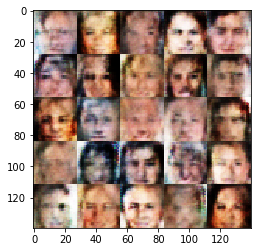

Epoch 1/1... Discriminator Loss: 1.2159... Generator Loss: 1.0461
Epoch 1/1... Discriminator Loss: 1.3838... Generator Loss: 0.6192
Epoch 1/1... Discriminator Loss: 1.3250... Generator Loss: 0.7108
Epoch 1/1... Discriminator Loss: 2.0885... Generator Loss: 1.5610
Epoch 1/1... Discriminator Loss: 1.4298... Generator Loss: 1.0077
Epoch 1/1... Discriminator Loss: 1.2278... Generator Loss: 0.9859
Epoch 1/1... Discriminator Loss: 1.3374... Generator Loss: 0.8409
Epoch 1/1... Discriminator Loss: 1.3440... Generator Loss: 0.8972
Epoch 1/1... Discriminator Loss: 1.3089... Generator Loss: 0.7228
Epoch 1/1... Discriminator Loss: 0.5424... Generator Loss: 3.0320
out_channel_dim 3


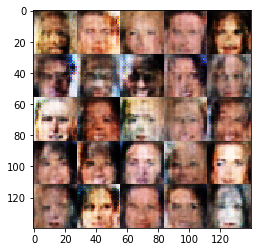

Epoch 1/1... Discriminator Loss: 0.3642... Generator Loss: 8.1189
Epoch 1/1... Discriminator Loss: 1.1422... Generator Loss: 0.7974
Epoch 1/1... Discriminator Loss: 1.5428... Generator Loss: 0.4540
Epoch 1/1... Discriminator Loss: 1.3081... Generator Loss: 0.6974
Epoch 1/1... Discriminator Loss: 1.5578... Generator Loss: 0.5927
Epoch 1/1... Discriminator Loss: 1.4433... Generator Loss: 0.5966
Epoch 1/1... Discriminator Loss: 1.2601... Generator Loss: 0.8462
Epoch 1/1... Discriminator Loss: 1.3978... Generator Loss: 0.7225
Epoch 1/1... Discriminator Loss: 1.4027... Generator Loss: 0.6860
Epoch 1/1... Discriminator Loss: 1.2584... Generator Loss: 0.9479
out_channel_dim 3


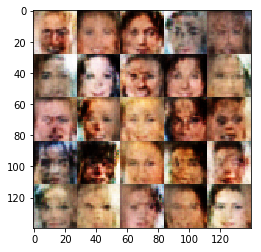

Epoch 1/1... Discriminator Loss: 1.2640... Generator Loss: 0.9803
Epoch 1/1... Discriminator Loss: 1.3057... Generator Loss: 0.8427
Epoch 1/1... Discriminator Loss: 1.5104... Generator Loss: 0.5222
Epoch 1/1... Discriminator Loss: 1.4015... Generator Loss: 0.6146
Epoch 1/1... Discriminator Loss: 1.1785... Generator Loss: 0.9729
Epoch 1/1... Discriminator Loss: 1.3556... Generator Loss: 0.7523
Epoch 1/1... Discriminator Loss: 1.2679... Generator Loss: 0.8191
Epoch 1/1... Discriminator Loss: 1.2688... Generator Loss: 0.9284
Epoch 1/1... Discriminator Loss: 1.2811... Generator Loss: 0.8393
Epoch 1/1... Discriminator Loss: 1.5122... Generator Loss: 0.5615
out_channel_dim 3


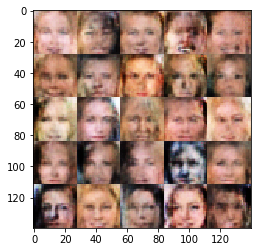

Epoch 1/1... Discriminator Loss: 1.1397... Generator Loss: 0.9739
Epoch 1/1... Discriminator Loss: 1.0790... Generator Loss: 1.2008
Epoch 1/1... Discriminator Loss: 1.9240... Generator Loss: 2.0313
Epoch 1/1... Discriminator Loss: 1.3267... Generator Loss: 0.7362
Epoch 1/1... Discriminator Loss: 1.3380... Generator Loss: 0.7708
Epoch 1/1... Discriminator Loss: 1.2900... Generator Loss: 0.8948
Epoch 1/1... Discriminator Loss: 1.3110... Generator Loss: 0.7557
Epoch 1/1... Discriminator Loss: 1.4635... Generator Loss: 0.7348
Epoch 1/1... Discriminator Loss: 1.3365... Generator Loss: 0.6822
Epoch 1/1... Discriminator Loss: 1.2623... Generator Loss: 1.0259
out_channel_dim 3


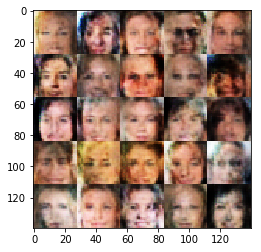

Epoch 1/1... Discriminator Loss: 1.3696... Generator Loss: 0.7468
Epoch 1/1... Discriminator Loss: 1.3748... Generator Loss: 0.7183
Epoch 1/1... Discriminator Loss: 1.5035... Generator Loss: 0.5475
Epoch 1/1... Discriminator Loss: 0.9587... Generator Loss: 1.4920
Epoch 1/1... Discriminator Loss: 1.3313... Generator Loss: 0.7616
Epoch 1/1... Discriminator Loss: 1.3588... Generator Loss: 0.6621
Epoch 1/1... Discriminator Loss: 1.3091... Generator Loss: 0.7031
Epoch 1/1... Discriminator Loss: 1.1471... Generator Loss: 1.1448
Epoch 1/1... Discriminator Loss: 1.2598... Generator Loss: 1.3186
Epoch 1/1... Discriminator Loss: 1.3927... Generator Loss: 0.6035
out_channel_dim 3


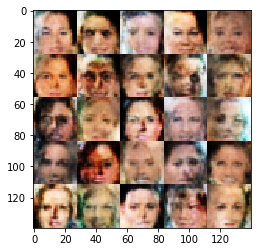

Epoch 1/1... Discriminator Loss: 1.3955... Generator Loss: 0.7000
Epoch 1/1... Discriminator Loss: 1.1716... Generator Loss: 0.9422
Epoch 1/1... Discriminator Loss: 1.2647... Generator Loss: 0.8212
Epoch 1/1... Discriminator Loss: 1.2709... Generator Loss: 0.9177
Epoch 1/1... Discriminator Loss: 1.2733... Generator Loss: 0.8744
Epoch 1/1... Discriminator Loss: 1.3518... Generator Loss: 0.8009
Epoch 1/1... Discriminator Loss: 1.1700... Generator Loss: 0.8434
Epoch 1/1... Discriminator Loss: 2.1379... Generator Loss: 1.8357
Epoch 1/1... Discriminator Loss: 1.2936... Generator Loss: 0.8086
Epoch 1/1... Discriminator Loss: 1.2530... Generator Loss: 0.9035
out_channel_dim 3


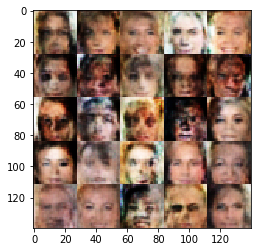

Epoch 1/1... Discriminator Loss: 1.3657... Generator Loss: 0.7215
Epoch 1/1... Discriminator Loss: 1.2640... Generator Loss: 0.8485
Epoch 1/1... Discriminator Loss: 1.2395... Generator Loss: 0.8326
Epoch 1/1... Discriminator Loss: 1.3293... Generator Loss: 0.6874
Epoch 1/1... Discriminator Loss: 1.2717... Generator Loss: 0.8837
Epoch 1/1... Discriminator Loss: 1.1810... Generator Loss: 1.1038
Epoch 1/1... Discriminator Loss: 1.2362... Generator Loss: 0.8478
Epoch 1/1... Discriminator Loss: 1.3850... Generator Loss: 1.1374
Epoch 1/1... Discriminator Loss: 1.4406... Generator Loss: 0.5685
Epoch 1/1... Discriminator Loss: 1.3102... Generator Loss: 0.7402
out_channel_dim 3


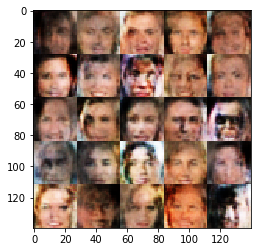

Epoch 1/1... Discriminator Loss: 1.2997... Generator Loss: 0.8026
Epoch 1/1... Discriminator Loss: 1.4653... Generator Loss: 0.5338
Epoch 1/1... Discriminator Loss: 1.3690... Generator Loss: 0.7677
Epoch 1/1... Discriminator Loss: 1.3919... Generator Loss: 0.7781
Epoch 1/1... Discriminator Loss: 1.3500... Generator Loss: 0.8497
Epoch 1/1... Discriminator Loss: 1.2967... Generator Loss: 0.8112
Epoch 1/1... Discriminator Loss: 1.2160... Generator Loss: 1.0140
Epoch 1/1... Discriminator Loss: 1.3145... Generator Loss: 0.6328
Epoch 1/1... Discriminator Loss: 1.2801... Generator Loss: 0.9210
Epoch 1/1... Discriminator Loss: 1.1074... Generator Loss: 1.1580
out_channel_dim 3


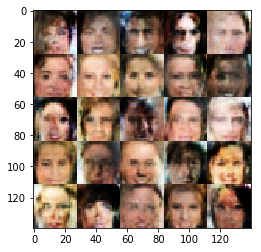

Epoch 1/1... Discriminator Loss: 1.2108... Generator Loss: 1.1026
Epoch 1/1... Discriminator Loss: 0.9959... Generator Loss: 1.3730
Epoch 1/1... Discriminator Loss: 1.3970... Generator Loss: 0.5810
Epoch 1/1... Discriminator Loss: 1.2578... Generator Loss: 1.5140
Epoch 1/1... Discriminator Loss: 1.7697... Generator Loss: 0.3364
Epoch 1/1... Discriminator Loss: 1.2028... Generator Loss: 0.9732
Epoch 1/1... Discriminator Loss: 1.1822... Generator Loss: 1.0410
Epoch 1/1... Discriminator Loss: 1.3950... Generator Loss: 0.6487
Epoch 1/1... Discriminator Loss: 1.4146... Generator Loss: 0.5559
Epoch 1/1... Discriminator Loss: 1.4018... Generator Loss: 0.7744
out_channel_dim 3


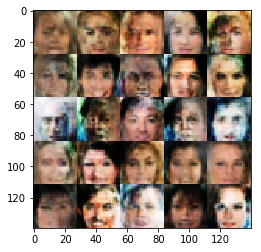

Epoch 1/1... Discriminator Loss: 1.3403... Generator Loss: 0.6782
Epoch 1/1... Discriminator Loss: 1.4053... Generator Loss: 0.6419
Epoch 1/1... Discriminator Loss: 1.3893... Generator Loss: 0.6842
Epoch 1/1... Discriminator Loss: 1.2957... Generator Loss: 0.7589
Epoch 1/1... Discriminator Loss: 1.3315... Generator Loss: 1.1514
Epoch 1/1... Discriminator Loss: 1.3470... Generator Loss: 0.8375
Epoch 1/1... Discriminator Loss: 1.1204... Generator Loss: 0.8978
Epoch 1/1... Discriminator Loss: 1.3054... Generator Loss: 1.0238
Epoch 1/1... Discriminator Loss: 1.5101... Generator Loss: 1.2787
Epoch 1/1... Discriminator Loss: 1.5717... Generator Loss: 0.4505
out_channel_dim 3


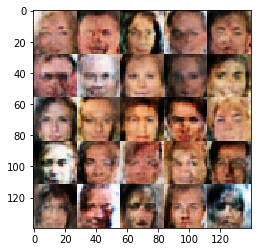

Epoch 1/1... Discriminator Loss: 0.7649... Generator Loss: 9.1167
Epoch 1/1... Discriminator Loss: 0.4452... Generator Loss: 5.1054
Epoch 1/1... Discriminator Loss: 1.1474... Generator Loss: 1.2448
Epoch 1/1... Discriminator Loss: 1.3773... Generator Loss: 1.1295
Epoch 1/1... Discriminator Loss: 1.1596... Generator Loss: 0.9214
Epoch 1/1... Discriminator Loss: 1.3049... Generator Loss: 0.8909
Epoch 1/1... Discriminator Loss: 1.3203... Generator Loss: 0.9393
Epoch 1/1... Discriminator Loss: 1.2694... Generator Loss: 0.9576
Epoch 1/1... Discriminator Loss: 1.2926... Generator Loss: 0.8328
Epoch 1/1... Discriminator Loss: 1.3416... Generator Loss: 0.9803
out_channel_dim 3


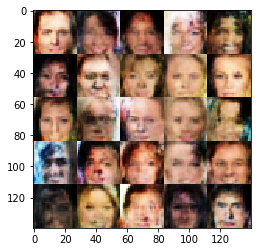

Epoch 1/1... Discriminator Loss: 1.4114... Generator Loss: 1.0860
Epoch 1/1... Discriminator Loss: 1.3098... Generator Loss: 0.6851
Epoch 1/1... Discriminator Loss: 1.3289... Generator Loss: 0.7497
Epoch 1/1... Discriminator Loss: 1.2882... Generator Loss: 0.9830
Epoch 1/1... Discriminator Loss: 1.3866... Generator Loss: 0.5637
Epoch 1/1... Discriminator Loss: 1.3413... Generator Loss: 0.6891
Epoch 1/1... Discriminator Loss: 1.2673... Generator Loss: 0.9584
Epoch 1/1... Discriminator Loss: 1.2091... Generator Loss: 0.8218
Epoch 1/1... Discriminator Loss: 1.3758... Generator Loss: 0.6657
Epoch 1/1... Discriminator Loss: 1.4150... Generator Loss: 0.6212
out_channel_dim 3


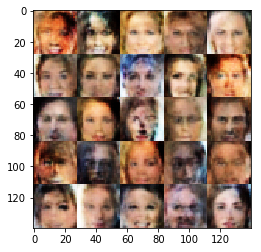

Epoch 1/1... Discriminator Loss: 1.2574... Generator Loss: 1.1401
Epoch 1/1... Discriminator Loss: 1.2248... Generator Loss: 1.0221
Epoch 1/1... Discriminator Loss: 1.3546... Generator Loss: 0.7303
Epoch 1/1... Discriminator Loss: 1.7331... Generator Loss: 1.4311
Epoch 1/1... Discriminator Loss: 1.3267... Generator Loss: 0.8232
Epoch 1/1... Discriminator Loss: 1.2076... Generator Loss: 0.8742
Epoch 1/1... Discriminator Loss: 1.3881... Generator Loss: 0.6011
Epoch 1/1... Discriminator Loss: 1.3644... Generator Loss: 0.8790
Epoch 1/1... Discriminator Loss: 1.2644... Generator Loss: 0.8078
Epoch 1/1... Discriminator Loss: 1.2682... Generator Loss: 0.7251
out_channel_dim 3


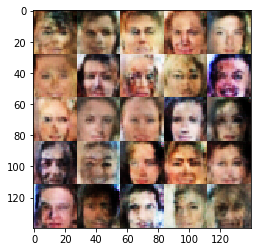

Epoch 1/1... Discriminator Loss: 1.1767... Generator Loss: 1.3042
Epoch 1/1... Discriminator Loss: 1.4228... Generator Loss: 0.7221
Epoch 1/1... Discriminator Loss: 1.3576... Generator Loss: 1.1190
Epoch 1/1... Discriminator Loss: 1.4916... Generator Loss: 1.0664
Epoch 1/1... Discriminator Loss: 1.3847... Generator Loss: 0.6794
Epoch 1/1... Discriminator Loss: 1.4019... Generator Loss: 0.7003
Epoch 1/1... Discriminator Loss: 1.3392... Generator Loss: 0.8517
Epoch 1/1... Discriminator Loss: 1.3235... Generator Loss: 0.6717
Epoch 1/1... Discriminator Loss: 1.3141... Generator Loss: 1.1141
Epoch 1/1... Discriminator Loss: 1.2747... Generator Loss: 1.0022
out_channel_dim 3


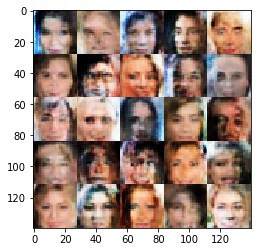

Epoch 1/1... Discriminator Loss: 1.3856... Generator Loss: 0.8173
Epoch 1/1... Discriminator Loss: 1.2290... Generator Loss: 0.8701
Epoch 1/1... Discriminator Loss: 1.3143... Generator Loss: 0.6990
Epoch 1/1... Discriminator Loss: 1.2670... Generator Loss: 1.1019
Epoch 1/1... Discriminator Loss: 1.2063... Generator Loss: 0.9043
Epoch 1/1... Discriminator Loss: 1.4848... Generator Loss: 0.6554
Epoch 1/1... Discriminator Loss: 1.4221... Generator Loss: 0.5859
Epoch 1/1... Discriminator Loss: 1.3337... Generator Loss: 1.0481
Epoch 1/1... Discriminator Loss: 1.2188... Generator Loss: 0.9360
Epoch 1/1... Discriminator Loss: 1.3507... Generator Loss: 0.8283
out_channel_dim 3


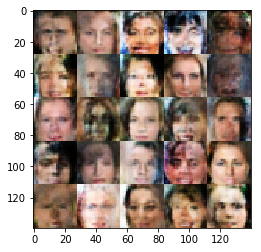

Epoch 1/1... Discriminator Loss: 1.3782... Generator Loss: 0.7073
Epoch 1/1... Discriminator Loss: 1.3467... Generator Loss: 0.6290
Epoch 1/1... Discriminator Loss: 1.3518... Generator Loss: 0.6797
Epoch 1/1... Discriminator Loss: 0.4458... Generator Loss: 9.8906
Epoch 1/1... Discriminator Loss: 1.7842... Generator Loss: 0.3709
Epoch 1/1... Discriminator Loss: 1.6540... Generator Loss: 0.3818
Epoch 1/1... Discriminator Loss: 1.1991... Generator Loss: 1.0690
Epoch 1/1... Discriminator Loss: 1.2756... Generator Loss: 1.0116
Epoch 1/1... Discriminator Loss: 1.1952... Generator Loss: 0.9793
Epoch 1/1... Discriminator Loss: 1.2640... Generator Loss: 0.9336
out_channel_dim 3


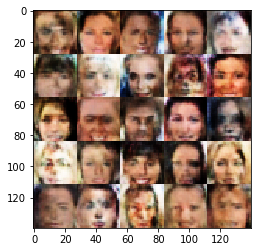

Epoch 1/1... Discriminator Loss: 1.3141... Generator Loss: 0.6550
Epoch 1/1... Discriminator Loss: 1.3608... Generator Loss: 0.6692
Epoch 1/1... Discriminator Loss: 1.4822... Generator Loss: 0.7570
Epoch 1/1... Discriminator Loss: 1.2394... Generator Loss: 0.8706
Epoch 1/1... Discriminator Loss: 1.3459... Generator Loss: 0.9063
Epoch 1/1... Discriminator Loss: 1.0422... Generator Loss: 1.1279
Epoch 1/1... Discriminator Loss: 1.2799... Generator Loss: 1.1524
Epoch 1/1... Discriminator Loss: 1.3730... Generator Loss: 0.6415
Epoch 1/1... Discriminator Loss: 1.3021... Generator Loss: 0.8984
Epoch 1/1... Discriminator Loss: 1.3113... Generator Loss: 0.7176
out_channel_dim 3


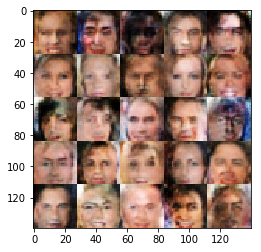

Epoch 1/1... Discriminator Loss: 1.4036... Generator Loss: 0.6590
Epoch 1/1... Discriminator Loss: 1.2156... Generator Loss: 1.1514
Epoch 1/1... Discriminator Loss: 1.6286... Generator Loss: 0.5677
Epoch 1/1... Discriminator Loss: 1.3382... Generator Loss: 0.7659
Epoch 1/1... Discriminator Loss: 1.4136... Generator Loss: 0.7228
Epoch 1/1... Discriminator Loss: 1.4423... Generator Loss: 0.9337
Epoch 1/1... Discriminator Loss: 1.3112... Generator Loss: 0.8400
Epoch 1/1... Discriminator Loss: 1.3693... Generator Loss: 0.8626
Epoch 1/1... Discriminator Loss: 1.5480... Generator Loss: 0.8293
Epoch 1/1... Discriminator Loss: 1.3065... Generator Loss: 1.0489
out_channel_dim 3


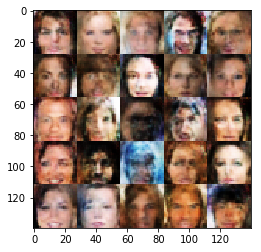

Epoch 1/1... Discriminator Loss: 1.4717... Generator Loss: 0.7326
Epoch 1/1... Discriminator Loss: 1.4977... Generator Loss: 0.8284
Epoch 1/1... Discriminator Loss: 1.1312... Generator Loss: 1.0301
Epoch 1/1... Discriminator Loss: 1.3159... Generator Loss: 0.7699
Epoch 1/1... Discriminator Loss: 1.2982... Generator Loss: 0.7740
Epoch 1/1... Discriminator Loss: 1.3775... Generator Loss: 0.8254
Epoch 1/1... Discriminator Loss: 1.2313... Generator Loss: 1.1410
Epoch 1/1... Discriminator Loss: 1.3417... Generator Loss: 1.0415
Epoch 1/1... Discriminator Loss: 1.5606... Generator Loss: 0.7298
Epoch 1/1... Discriminator Loss: 1.3704... Generator Loss: 0.8508
out_channel_dim 3


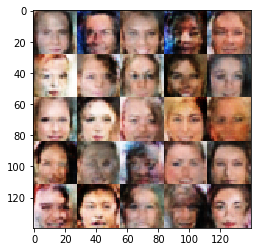

Epoch 1/1... Discriminator Loss: 1.4061... Generator Loss: 0.8613
Epoch 1/1... Discriminator Loss: 1.4591... Generator Loss: 0.6666
Epoch 1/1... Discriminator Loss: 1.3093... Generator Loss: 0.6853
Epoch 1/1... Discriminator Loss: 1.2554... Generator Loss: 1.1172
Epoch 1/1... Discriminator Loss: 1.3880... Generator Loss: 0.8338
Epoch 1/1... Discriminator Loss: 1.4526... Generator Loss: 1.2119
Epoch 1/1... Discriminator Loss: 1.3150... Generator Loss: 0.9289
Epoch 1/1... Discriminator Loss: 1.3565... Generator Loss: 0.7181
Epoch 1/1... Discriminator Loss: 1.3704... Generator Loss: 0.8046
Epoch 1/1... Discriminator Loss: 1.7389... Generator Loss: 0.3887
out_channel_dim 3


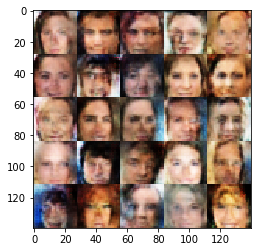

Epoch 1/1... Discriminator Loss: 1.3558... Generator Loss: 0.6438
Epoch 1/1... Discriminator Loss: 1.2674... Generator Loss: 0.8171
Epoch 1/1... Discriminator Loss: 1.3180... Generator Loss: 0.8469
Epoch 1/1... Discriminator Loss: 1.1620... Generator Loss: 0.9471
Epoch 1/1... Discriminator Loss: 1.4403... Generator Loss: 0.5620
Epoch 1/1... Discriminator Loss: 1.2657... Generator Loss: 0.8126
Epoch 1/1... Discriminator Loss: 1.3654... Generator Loss: 0.7007
Epoch 1/1... Discriminator Loss: 1.3928... Generator Loss: 0.6496
Epoch 1/1... Discriminator Loss: 1.2873... Generator Loss: 0.9126
Epoch 1/1... Discriminator Loss: 1.3375... Generator Loss: 0.7731
out_channel_dim 3


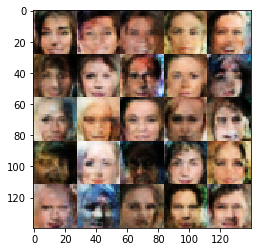

Epoch 1/1... Discriminator Loss: 1.2687... Generator Loss: 1.2020
Epoch 1/1... Discriminator Loss: 1.3962... Generator Loss: 0.6224
Epoch 1/1... Discriminator Loss: 1.5397... Generator Loss: 0.6039
Epoch 1/1... Discriminator Loss: 1.3725... Generator Loss: 0.7006
Epoch 1/1... Discriminator Loss: 1.3781... Generator Loss: 0.7254
Epoch 1/1... Discriminator Loss: 1.3866... Generator Loss: 0.6758
Epoch 1/1... Discriminator Loss: 1.2333... Generator Loss: 0.9215
Epoch 1/1... Discriminator Loss: 1.4046... Generator Loss: 0.6608
Epoch 1/1... Discriminator Loss: 1.2448... Generator Loss: 1.0766
Epoch 1/1... Discriminator Loss: 1.3551... Generator Loss: 0.7823
out_channel_dim 3


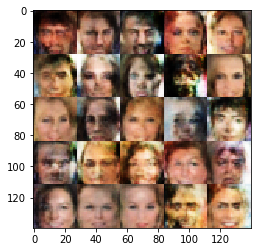

Epoch 1/1... Discriminator Loss: 1.3775... Generator Loss: 0.7704
Epoch 1/1... Discriminator Loss: 1.4062... Generator Loss: 0.6313
Epoch 1/1... Discriminator Loss: 1.4731... Generator Loss: 0.5686
Epoch 1/1... Discriminator Loss: 1.5607... Generator Loss: 0.4879
Epoch 1/1... Discriminator Loss: 1.4119... Generator Loss: 0.7047
Epoch 1/1... Discriminator Loss: 1.3163... Generator Loss: 0.7278
Epoch 1/1... Discriminator Loss: 1.4507... Generator Loss: 0.6525
Epoch 1/1... Discriminator Loss: 1.3601... Generator Loss: 0.7855
Epoch 1/1... Discriminator Loss: 1.3920... Generator Loss: 0.6441
Epoch 1/1... Discriminator Loss: 1.3919... Generator Loss: 0.8473
out_channel_dim 3


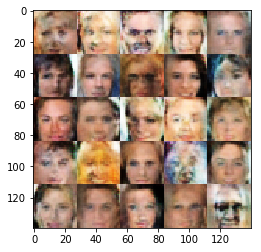

Epoch 1/1... Discriminator Loss: 1.3442... Generator Loss: 0.8368
Epoch 1/1... Discriminator Loss: 1.3277... Generator Loss: 0.7561
Epoch 1/1... Discriminator Loss: 1.3514... Generator Loss: 0.6610
Epoch 1/1... Discriminator Loss: 1.2693... Generator Loss: 1.1264
Epoch 1/1... Discriminator Loss: 1.2596... Generator Loss: 0.8504
Epoch 1/1... Discriminator Loss: 1.3682... Generator Loss: 0.6691
Epoch 1/1... Discriminator Loss: 1.4368... Generator Loss: 0.5181
Epoch 1/1... Discriminator Loss: 1.4167... Generator Loss: 0.7283
Epoch 1/1... Discriminator Loss: 1.2894... Generator Loss: 0.7786
Epoch 1/1... Discriminator Loss: 1.4662... Generator Loss: 0.6581
out_channel_dim 3


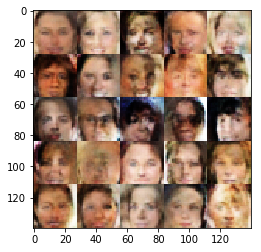

Epoch 1/1... Discriminator Loss: 1.4963... Generator Loss: 0.6061
Epoch 1/1... Discriminator Loss: 1.3731... Generator Loss: 0.8357
Epoch 1/1... Discriminator Loss: 1.3238... Generator Loss: 0.7643
Epoch 1/1... Discriminator Loss: 1.3203... Generator Loss: 0.8069
Epoch 1/1... Discriminator Loss: 1.5217... Generator Loss: 0.5202
Epoch 1/1... Discriminator Loss: 1.4106... Generator Loss: 0.5925
Epoch 1/1... Discriminator Loss: 1.4267... Generator Loss: 0.6798
Epoch 1/1... Discriminator Loss: 1.4425... Generator Loss: 0.7708
Epoch 1/1... Discriminator Loss: 1.3672... Generator Loss: 0.8167
Epoch 1/1... Discriminator Loss: 1.4431... Generator Loss: 0.6233
out_channel_dim 3


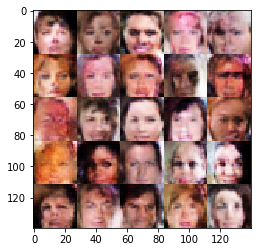

Epoch 1/1... Discriminator Loss: 1.3754... Generator Loss: 0.7099
Epoch 1/1... Discriminator Loss: 1.3920... Generator Loss: 0.5981
Epoch 1/1... Discriminator Loss: 1.4192... Generator Loss: 0.5857
Epoch 1/1... Discriminator Loss: 1.4249... Generator Loss: 0.5896
Epoch 1/1... Discriminator Loss: 1.4605... Generator Loss: 0.6958
Epoch 1/1... Discriminator Loss: 1.4263... Generator Loss: 0.6100
Epoch 1/1... Discriminator Loss: 1.3394... Generator Loss: 0.7340
Epoch 1/1... Discriminator Loss: 1.2113... Generator Loss: 0.8189
Epoch 1/1... Discriminator Loss: 1.5857... Generator Loss: 0.4932
Epoch 1/1... Discriminator Loss: 1.3849... Generator Loss: 0.8653
out_channel_dim 3


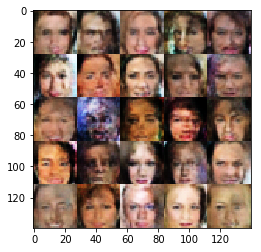

Epoch 1/1... Discriminator Loss: 1.2893... Generator Loss: 0.8940
Epoch 1/1... Discriminator Loss: 1.3561... Generator Loss: 0.7640
Epoch 1/1... Discriminator Loss: 1.3835... Generator Loss: 0.8476
Epoch 1/1... Discriminator Loss: 1.0145... Generator Loss: 1.4524
Epoch 1/1... Discriminator Loss: 1.4691... Generator Loss: 0.6804
Epoch 1/1... Discriminator Loss: 1.4282... Generator Loss: 0.6421
Epoch 1/1... Discriminator Loss: 1.4155... Generator Loss: 0.6498
Epoch 1/1... Discriminator Loss: 1.2049... Generator Loss: 0.8790
Epoch 1/1... Discriminator Loss: 1.4369... Generator Loss: 0.7758
Epoch 1/1... Discriminator Loss: 1.3359... Generator Loss: 0.8119
out_channel_dim 3


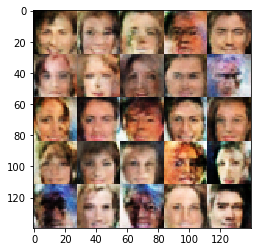

Epoch 1/1... Discriminator Loss: 1.2279... Generator Loss: 0.8667
Epoch 1/1... Discriminator Loss: 1.4063... Generator Loss: 0.7855
Epoch 1/1... Discriminator Loss: 1.6941... Generator Loss: 0.5065
Epoch 1/1... Discriminator Loss: 1.4265... Generator Loss: 0.5463
Epoch 1/1... Discriminator Loss: 1.4507... Generator Loss: 0.6186
Epoch 1/1... Discriminator Loss: 1.3727... Generator Loss: 1.2003
Epoch 1/1... Discriminator Loss: 1.3532... Generator Loss: 0.7004
Epoch 1/1... Discriminator Loss: 1.3710... Generator Loss: 0.9082
Epoch 1/1... Discriminator Loss: 1.3595... Generator Loss: 0.7074
Epoch 1/1... Discriminator Loss: 1.4568... Generator Loss: 0.7887
out_channel_dim 3


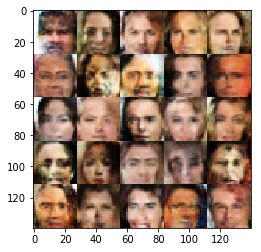

Epoch 1/1... Discriminator Loss: 1.4222... Generator Loss: 0.7239
Epoch 1/1... Discriminator Loss: 1.3228... Generator Loss: 0.8362
Epoch 1/1... Discriminator Loss: 1.3335... Generator Loss: 0.7401
Epoch 1/1... Discriminator Loss: 1.5193... Generator Loss: 0.6631
Epoch 1/1... Discriminator Loss: 1.3614... Generator Loss: 1.0192
Epoch 1/1... Discriminator Loss: 1.5095... Generator Loss: 1.0751
Epoch 1/1... Discriminator Loss: 1.4482... Generator Loss: 0.7202
Epoch 1/1... Discriminator Loss: 1.4124... Generator Loss: 0.7470
Epoch 1/1... Discriminator Loss: 1.3821... Generator Loss: 0.7125
Epoch 1/1... Discriminator Loss: 1.5146... Generator Loss: 0.8228
out_channel_dim 3


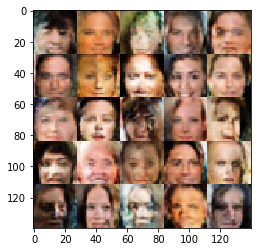

Epoch 1/1... Discriminator Loss: 1.4277... Generator Loss: 0.7092
Epoch 1/1... Discriminator Loss: 1.3919... Generator Loss: 0.6186
Epoch 1/1... Discriminator Loss: 1.1977... Generator Loss: 0.9212
Epoch 1/1... Discriminator Loss: 1.3110... Generator Loss: 0.9034
Epoch 1/1... Discriminator Loss: 1.3501... Generator Loss: 0.7814
Epoch 1/1... Discriminator Loss: 1.4264... Generator Loss: 0.6026
Epoch 1/1... Discriminator Loss: 1.3741... Generator Loss: 0.7627
Epoch 1/1... Discriminator Loss: 1.4020... Generator Loss: 1.0795
Epoch 1/1... Discriminator Loss: 1.7728... Generator Loss: 0.3001
Epoch 1/1... Discriminator Loss: 1.5045... Generator Loss: 0.5784
out_channel_dim 3


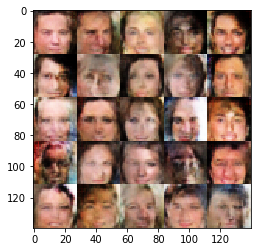

Epoch 1/1... Discriminator Loss: 1.3740... Generator Loss: 0.6654
Epoch 1/1... Discriminator Loss: 1.4101... Generator Loss: 0.7656
Epoch 1/1... Discriminator Loss: 1.3411... Generator Loss: 0.8213
Epoch 1/1... Discriminator Loss: 1.4211... Generator Loss: 0.6466
Epoch 1/1... Discriminator Loss: 1.3409... Generator Loss: 0.7487
Epoch 1/1... Discriminator Loss: 1.3575... Generator Loss: 0.7557
Epoch 1/1... Discriminator Loss: 1.3141... Generator Loss: 0.9232
Epoch 1/1... Discriminator Loss: 1.3135... Generator Loss: 0.8132
Epoch 1/1... Discriminator Loss: 1.4254... Generator Loss: 0.7649
Epoch 1/1... Discriminator Loss: 1.3732... Generator Loss: 0.6650
out_channel_dim 3


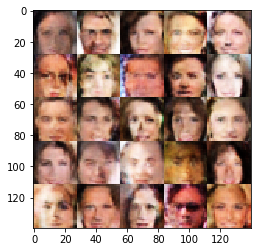

Epoch 1/1... Discriminator Loss: 1.5159... Generator Loss: 0.6180
Epoch 1/1... Discriminator Loss: 1.4011... Generator Loss: 0.6457
Epoch 1/1... Discriminator Loss: 1.2419... Generator Loss: 0.8113
Epoch 1/1... Discriminator Loss: 1.3175... Generator Loss: 0.7847
Epoch 1/1... Discriminator Loss: 1.3826... Generator Loss: 0.9732
Epoch 1/1... Discriminator Loss: 1.4098... Generator Loss: 0.6895
Epoch 1/1... Discriminator Loss: 1.3384... Generator Loss: 0.8166
Epoch 1/1... Discriminator Loss: 1.4128... Generator Loss: 0.7616
Epoch 1/1... Discriminator Loss: 1.2258... Generator Loss: 0.9200
Epoch 1/1... Discriminator Loss: 1.4868... Generator Loss: 0.7703
out_channel_dim 3


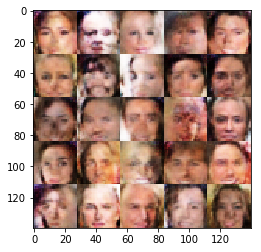

Epoch 1/1... Discriminator Loss: 1.2518... Generator Loss: 0.9680
Epoch 1/1... Discriminator Loss: 1.3589... Generator Loss: 0.7020
Epoch 1/1... Discriminator Loss: 1.3168... Generator Loss: 0.8215
Epoch 1/1... Discriminator Loss: 1.3534... Generator Loss: 0.9084
Epoch 1/1... Discriminator Loss: 1.3580... Generator Loss: 0.8338
Epoch 1/1... Discriminator Loss: 1.4799... Generator Loss: 0.6277
Epoch 1/1... Discriminator Loss: 1.4548... Generator Loss: 0.6916
Epoch 1/1... Discriminator Loss: 1.3227... Generator Loss: 0.7635
Epoch 1/1... Discriminator Loss: 1.4218... Generator Loss: 0.8049
Epoch 1/1... Discriminator Loss: 1.3598... Generator Loss: 0.9863
out_channel_dim 3


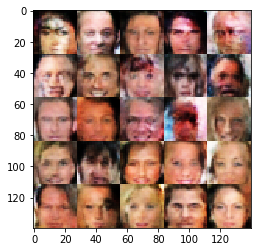

Epoch 1/1... Discriminator Loss: 1.4033... Generator Loss: 0.7841
Epoch 1/1... Discriminator Loss: 1.5581... Generator Loss: 0.5993
Epoch 1/1... Discriminator Loss: 1.2970... Generator Loss: 0.8876
Epoch 1/1... Discriminator Loss: 1.2423... Generator Loss: 0.7659
Epoch 1/1... Discriminator Loss: 1.3729... Generator Loss: 0.7158
Epoch 1/1... Discriminator Loss: 1.4851... Generator Loss: 0.5220
Epoch 1/1... Discriminator Loss: 1.3801... Generator Loss: 0.7337
Epoch 1/1... Discriminator Loss: 1.2598... Generator Loss: 0.9586
Epoch 1/1... Discriminator Loss: 1.3743... Generator Loss: 0.7806
Epoch 1/1... Discriminator Loss: 1.3857... Generator Loss: 0.7899
out_channel_dim 3


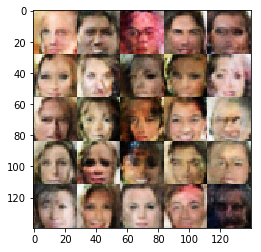

Epoch 1/1... Discriminator Loss: 1.3611... Generator Loss: 0.8006
Epoch 1/1... Discriminator Loss: 1.3983... Generator Loss: 0.6646
Epoch 1/1... Discriminator Loss: 1.2315... Generator Loss: 1.0526
Epoch 1/1... Discriminator Loss: 1.7237... Generator Loss: 0.7095
Epoch 1/1... Discriminator Loss: 1.4413... Generator Loss: 0.6901
Epoch 1/1... Discriminator Loss: 1.4143... Generator Loss: 0.6064
Epoch 1/1... Discriminator Loss: 1.3897... Generator Loss: 0.7218
Epoch 1/1... Discriminator Loss: 1.3603... Generator Loss: 0.7780
Epoch 1/1... Discriminator Loss: 1.3643... Generator Loss: 0.6936
Epoch 1/1... Discriminator Loss: 1.3938... Generator Loss: 0.8320
out_channel_dim 3


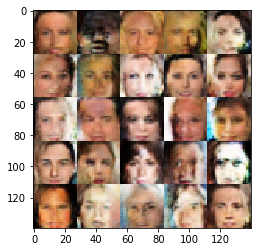

Epoch 1/1... Discriminator Loss: 1.3799... Generator Loss: 0.8110
Epoch 1/1... Discriminator Loss: 1.6785... Generator Loss: 0.3889
Epoch 1/1... Discriminator Loss: 1.4465... Generator Loss: 0.9044
Epoch 1/1... Discriminator Loss: 1.3744... Generator Loss: 0.9651
Epoch 1/1... Discriminator Loss: 1.2864... Generator Loss: 0.8213
Epoch 1/1... Discriminator Loss: 1.2636... Generator Loss: 1.0700
Epoch 1/1... Discriminator Loss: 1.4250... Generator Loss: 0.7225
Epoch 1/1... Discriminator Loss: 1.3928... Generator Loss: 0.7395
Epoch 1/1... Discriminator Loss: 1.5004... Generator Loss: 0.6229
Epoch 1/1... Discriminator Loss: 1.4820... Generator Loss: 0.6174
out_channel_dim 3


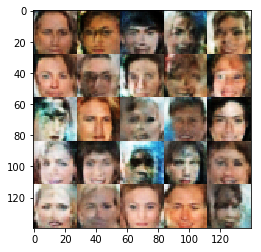

Epoch 1/1... Discriminator Loss: 1.4337... Generator Loss: 0.6719
Epoch 1/1... Discriminator Loss: 1.3572... Generator Loss: 0.9035
Epoch 1/1... Discriminator Loss: 1.3769... Generator Loss: 0.7444
Epoch 1/1... Discriminator Loss: 1.3419... Generator Loss: 0.7633
Epoch 1/1... Discriminator Loss: 1.1875... Generator Loss: 0.9072
Epoch 1/1... Discriminator Loss: 1.3570... Generator Loss: 0.7714
Epoch 1/1... Discriminator Loss: 1.5971... Generator Loss: 0.6936
Epoch 1/1... Discriminator Loss: 1.3202... Generator Loss: 0.7473
Epoch 1/1... Discriminator Loss: 1.3213... Generator Loss: 0.8130
Epoch 1/1... Discriminator Loss: 1.3239... Generator Loss: 0.7361
out_channel_dim 3


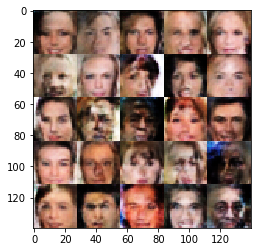

Epoch 1/1... Discriminator Loss: 1.4586... Generator Loss: 0.5818
Epoch 1/1... Discriminator Loss: 1.4145... Generator Loss: 0.6460
Epoch 1/1... Discriminator Loss: 1.4072... Generator Loss: 0.6687
Epoch 1/1... Discriminator Loss: 1.0158... Generator Loss: 1.3970
Epoch 1/1... Discriminator Loss: 1.4583... Generator Loss: 0.5826
Epoch 1/1... Discriminator Loss: 1.3127... Generator Loss: 0.6802
Epoch 1/1... Discriminator Loss: 1.3932... Generator Loss: 0.6819
Epoch 1/1... Discriminator Loss: 1.4130... Generator Loss: 0.7742
Epoch 1/1... Discriminator Loss: 1.4319... Generator Loss: 0.9121
Epoch 1/1... Discriminator Loss: 1.4524... Generator Loss: 0.6225
out_channel_dim 3


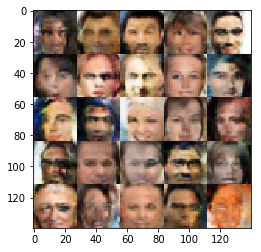

Epoch 1/1... Discriminator Loss: 1.5122... Generator Loss: 0.5366
Epoch 1/1... Discriminator Loss: 1.4984... Generator Loss: 0.5405
Epoch 1/1... Discriminator Loss: 1.4746... Generator Loss: 0.7429
Epoch 1/1... Discriminator Loss: 1.3884... Generator Loss: 0.7598
Epoch 1/1... Discriminator Loss: 1.4951... Generator Loss: 0.7030
Epoch 1/1... Discriminator Loss: 1.3148... Generator Loss: 0.8641
Epoch 1/1... Discriminator Loss: 1.3905... Generator Loss: 0.8167
Epoch 1/1... Discriminator Loss: 1.3617... Generator Loss: 0.7386
Epoch 1/1... Discriminator Loss: 1.3297... Generator Loss: 0.7967
Epoch 1/1... Discriminator Loss: 1.4466... Generator Loss: 0.6051
out_channel_dim 3


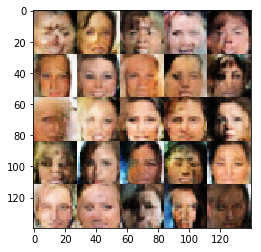

Epoch 1/1... Discriminator Loss: 1.4089... Generator Loss: 0.7257
Epoch 1/1... Discriminator Loss: 1.3999... Generator Loss: 0.7094
Epoch 1/1... Discriminator Loss: 1.3322... Generator Loss: 1.0207
Epoch 1/1... Discriminator Loss: 1.3967... Generator Loss: 0.6274
Epoch 1/1... Discriminator Loss: 1.5645... Generator Loss: 0.5994
Epoch 1/1... Discriminator Loss: 1.4312... Generator Loss: 0.6601
Epoch 1/1... Discriminator Loss: 1.2695... Generator Loss: 1.0200
Epoch 1/1... Discriminator Loss: 1.3418... Generator Loss: 0.9088
Epoch 1/1... Discriminator Loss: 1.4027... Generator Loss: 0.7658
Epoch 1/1... Discriminator Loss: 1.3635... Generator Loss: 0.7973
out_channel_dim 3


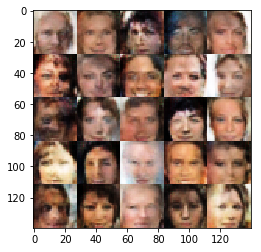

Epoch 1/1... Discriminator Loss: 1.2889... Generator Loss: 0.7656
Epoch 1/1... Discriminator Loss: 1.2665... Generator Loss: 0.8671
Epoch 1/1... Discriminator Loss: 1.2709... Generator Loss: 0.9275
Epoch 1/1... Discriminator Loss: 1.4086... Generator Loss: 0.8014
Epoch 1/1... Discriminator Loss: 1.4057... Generator Loss: 0.7199
Epoch 1/1... Discriminator Loss: 1.4242... Generator Loss: 0.6102
Epoch 1/1... Discriminator Loss: 1.2924... Generator Loss: 0.7710
Epoch 1/1... Discriminator Loss: 1.3806... Generator Loss: 0.8550
Epoch 1/1... Discriminator Loss: 1.3533... Generator Loss: 0.8657
Epoch 1/1... Discriminator Loss: 1.4079... Generator Loss: 0.6940
out_channel_dim 3


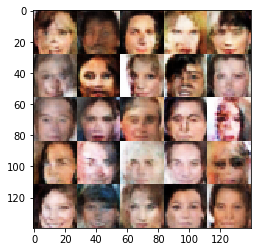

Epoch 1/1... Discriminator Loss: 1.3703... Generator Loss: 0.9246
Epoch 1/1... Discriminator Loss: 1.3824... Generator Loss: 0.6701
Epoch 1/1... Discriminator Loss: 1.3989... Generator Loss: 0.6537
Epoch 1/1... Discriminator Loss: 1.2958... Generator Loss: 0.8093
Epoch 1/1... Discriminator Loss: 1.6343... Generator Loss: 0.5865
Epoch 1/1... Discriminator Loss: 1.3626... Generator Loss: 0.7439
Epoch 1/1... Discriminator Loss: 1.5143... Generator Loss: 0.5473
Epoch 1/1... Discriminator Loss: 1.3718... Generator Loss: 0.7563
Epoch 1/1... Discriminator Loss: 1.4071... Generator Loss: 0.7825
Epoch 1/1... Discriminator Loss: 1.2659... Generator Loss: 0.8192
out_channel_dim 3


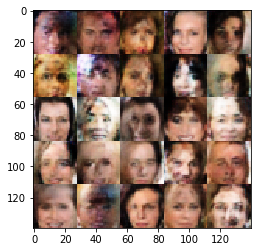

Epoch 1/1... Discriminator Loss: 1.4538... Generator Loss: 0.7524
Epoch 1/1... Discriminator Loss: 1.4882... Generator Loss: 0.6237
Epoch 1/1... Discriminator Loss: 1.4488... Generator Loss: 0.5651
Epoch 1/1... Discriminator Loss: 1.4818... Generator Loss: 0.6566
Epoch 1/1... Discriminator Loss: 1.3555... Generator Loss: 0.7250
Epoch 1/1... Discriminator Loss: 1.5698... Generator Loss: 0.8320
Epoch 1/1... Discriminator Loss: 1.4546... Generator Loss: 0.6549
Epoch 1/1... Discriminator Loss: 1.4133... Generator Loss: 0.6909
Epoch 1/1... Discriminator Loss: 1.3262... Generator Loss: 0.8483
Epoch 1/1... Discriminator Loss: 1.3244... Generator Loss: 0.7925
out_channel_dim 3


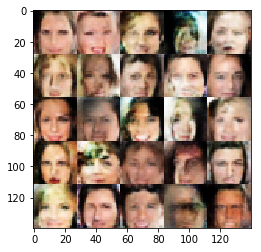

Epoch 1/1... Discriminator Loss: 1.5338... Generator Loss: 0.9376
Epoch 1/1... Discriminator Loss: 1.4870... Generator Loss: 0.6375
Epoch 1/1... Discriminator Loss: 1.2356... Generator Loss: 0.7299
Epoch 1/1... Discriminator Loss: 1.4433... Generator Loss: 1.2014
Epoch 1/1... Discriminator Loss: 1.3210... Generator Loss: 0.6951
Epoch 1/1... Discriminator Loss: 1.3909... Generator Loss: 0.6704
Epoch 1/1... Discriminator Loss: 1.4289... Generator Loss: 0.6992
Epoch 1/1... Discriminator Loss: 1.3522... Generator Loss: 0.9861
Epoch 1/1... Discriminator Loss: 1.3189... Generator Loss: 0.7861
Epoch 1/1... Discriminator Loss: 1.3925... Generator Loss: 0.7403
out_channel_dim 3


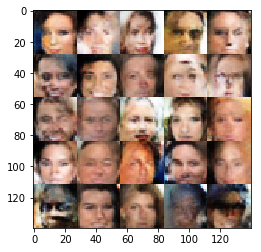

Epoch 1/1... Discriminator Loss: 1.4628... Generator Loss: 0.8529
Epoch 1/1... Discriminator Loss: 1.2915... Generator Loss: 0.8311
Epoch 1/1... Discriminator Loss: 1.1857... Generator Loss: 1.1204
Epoch 1/1... Discriminator Loss: 1.4781... Generator Loss: 0.4923
Epoch 1/1... Discriminator Loss: 1.1734... Generator Loss: 1.0478
Epoch 1/1... Discriminator Loss: 1.4023... Generator Loss: 0.7794
Epoch 1/1... Discriminator Loss: 1.4026... Generator Loss: 0.6443
Epoch 1/1... Discriminator Loss: 1.3807... Generator Loss: 0.8091
Epoch 1/1... Discriminator Loss: 1.3861... Generator Loss: 0.7666
Epoch 1/1... Discriminator Loss: 1.2462... Generator Loss: 1.1990
out_channel_dim 3


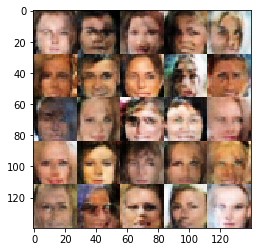

Epoch 1/1... Discriminator Loss: 1.3269... Generator Loss: 0.8912
Epoch 1/1... Discriminator Loss: 1.2490... Generator Loss: 0.9397
Epoch 1/1... Discriminator Loss: 1.3695... Generator Loss: 0.7737
Epoch 1/1... Discriminator Loss: 1.4105... Generator Loss: 0.6596
Epoch 1/1... Discriminator Loss: 1.5704... Generator Loss: 0.4598
Epoch 1/1... Discriminator Loss: 1.3925... Generator Loss: 0.7265
Epoch 1/1... Discriminator Loss: 1.4561... Generator Loss: 0.6923
Epoch 1/1... Discriminator Loss: 1.4602... Generator Loss: 0.6309
Epoch 1/1... Discriminator Loss: 1.3505... Generator Loss: 0.8350
Epoch 1/1... Discriminator Loss: 1.3866... Generator Loss: 0.7125
out_channel_dim 3


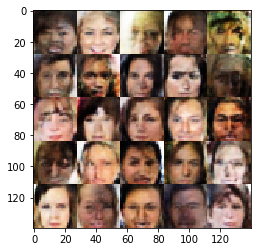

Epoch 1/1... Discriminator Loss: 1.2246... Generator Loss: 0.7908
Epoch 1/1... Discriminator Loss: 1.4346... Generator Loss: 0.6882
Epoch 1/1... Discriminator Loss: 1.4327... Generator Loss: 0.5793
Epoch 1/1... Discriminator Loss: 1.4766... Generator Loss: 0.7926
Epoch 1/1... Discriminator Loss: 1.4286... Generator Loss: 0.6203
Epoch 1/1... Discriminator Loss: 1.3830... Generator Loss: 0.7204
Epoch 1/1... Discriminator Loss: 1.4451... Generator Loss: 0.8133
Epoch 1/1... Discriminator Loss: 1.3628... Generator Loss: 0.7837
Epoch 1/1... Discriminator Loss: 1.3919... Generator Loss: 0.9576
Epoch 1/1... Discriminator Loss: 1.3999... Generator Loss: 0.5719
out_channel_dim 3


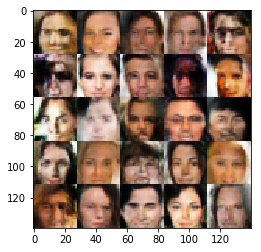

Epoch 1/1... Discriminator Loss: 1.4963... Generator Loss: 0.5563
Epoch 1/1... Discriminator Loss: 1.3359... Generator Loss: 0.8652
Epoch 1/1... Discriminator Loss: 1.4301... Generator Loss: 0.6754
Epoch 1/1... Discriminator Loss: 1.3218... Generator Loss: 1.0297
Epoch 1/1... Discriminator Loss: 1.2996... Generator Loss: 1.0469
Epoch 1/1... Discriminator Loss: 1.4148... Generator Loss: 0.8358
Epoch 1/1... Discriminator Loss: 1.4273... Generator Loss: 0.7295
Epoch 1/1... Discriminator Loss: 1.4488... Generator Loss: 0.6202
Epoch 1/1... Discriminator Loss: 1.3727... Generator Loss: 0.7415
Epoch 1/1... Discriminator Loss: 1.3524... Generator Loss: 0.8104
out_channel_dim 3


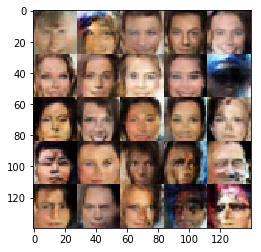

Epoch 1/1... Discriminator Loss: 1.4979... Generator Loss: 0.6718
Epoch 1/1... Discriminator Loss: 1.4156... Generator Loss: 0.7537
Epoch 1/1... Discriminator Loss: 1.3555... Generator Loss: 0.9255
Epoch 1/1... Discriminator Loss: 1.4653... Generator Loss: 0.6764
Epoch 1/1... Discriminator Loss: 1.4634... Generator Loss: 0.8513
Epoch 1/1... Discriminator Loss: 1.3672... Generator Loss: 0.6780
Epoch 1/1... Discriminator Loss: 1.4130... Generator Loss: 0.6611
Epoch 1/1... Discriminator Loss: 1.3736... Generator Loss: 0.7746
Epoch 1/1... Discriminator Loss: 1.4182... Generator Loss: 0.8133
Epoch 1/1... Discriminator Loss: 1.5462... Generator Loss: 0.5536
out_channel_dim 3


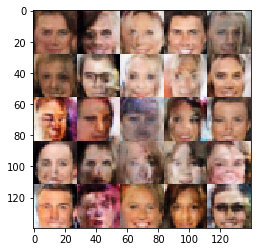

Epoch 1/1... Discriminator Loss: 1.3829... Generator Loss: 0.9158
Epoch 1/1... Discriminator Loss: 1.3875... Generator Loss: 0.7825
Epoch 1/1... Discriminator Loss: 1.4458... Generator Loss: 0.7748
Epoch 1/1... Discriminator Loss: 1.3905... Generator Loss: 0.7298
Epoch 1/1... Discriminator Loss: 1.3937... Generator Loss: 0.8582
Epoch 1/1... Discriminator Loss: 1.5044... Generator Loss: 0.7320
Epoch 1/1... Discriminator Loss: 1.2421... Generator Loss: 0.7936
Epoch 1/1... Discriminator Loss: 1.3264... Generator Loss: 0.7403
Epoch 1/1... Discriminator Loss: 1.6114... Generator Loss: 0.4966
Epoch 1/1... Discriminator Loss: 1.3028... Generator Loss: 0.7515
out_channel_dim 3


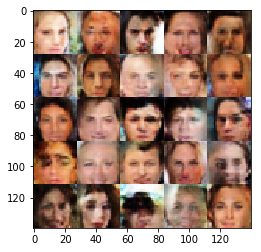

Epoch 1/1... Discriminator Loss: 1.4055... Generator Loss: 1.0368
Epoch 1/1... Discriminator Loss: 1.4151... Generator Loss: 0.7168
Epoch 1/1... Discriminator Loss: 1.8487... Generator Loss: 0.2921
Epoch 1/1... Discriminator Loss: 1.4966... Generator Loss: 0.7480
Epoch 1/1... Discriminator Loss: 1.3766... Generator Loss: 0.9224
Epoch 1/1... Discriminator Loss: 0.9294... Generator Loss: 1.5806
Epoch 1/1... Discriminator Loss: 1.5999... Generator Loss: 0.5070
Epoch 1/1... Discriminator Loss: 1.3585... Generator Loss: 0.7719
Epoch 1/1... Discriminator Loss: 1.5089... Generator Loss: 0.5897
Epoch 1/1... Discriminator Loss: 1.3930... Generator Loss: 0.7351
out_channel_dim 3


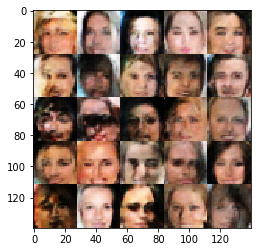

Epoch 1/1... Discriminator Loss: 1.4006... Generator Loss: 0.7171
Epoch 1/1... Discriminator Loss: 1.3693... Generator Loss: 0.8453
Epoch 1/1... Discriminator Loss: 1.4305... Generator Loss: 0.7030
Epoch 1/1... Discriminator Loss: 1.3690... Generator Loss: 0.8739
Epoch 1/1... Discriminator Loss: 1.4551... Generator Loss: 0.7720
Epoch 1/1... Discriminator Loss: 1.4056... Generator Loss: 0.6836
Epoch 1/1... Discriminator Loss: 1.3358... Generator Loss: 0.8220
Epoch 1/1... Discriminator Loss: 1.4116... Generator Loss: 0.7158
Epoch 1/1... Discriminator Loss: 1.4659... Generator Loss: 0.6251
Epoch 1/1... Discriminator Loss: 1.3601... Generator Loss: 0.7080
out_channel_dim 3


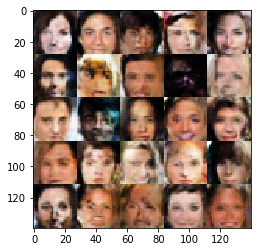

Epoch 1/1... Discriminator Loss: 1.3735... Generator Loss: 0.9860
Epoch 1/1... Discriminator Loss: 1.1448... Generator Loss: 0.9959
Epoch 1/1... Discriminator Loss: 1.5028... Generator Loss: 0.5692
Epoch 1/1... Discriminator Loss: 1.3926... Generator Loss: 0.7894
Epoch 1/1... Discriminator Loss: 1.4671... Generator Loss: 0.6491
Epoch 1/1... Discriminator Loss: 1.4817... Generator Loss: 0.6620
Epoch 1/1... Discriminator Loss: 1.2852... Generator Loss: 0.8564
Epoch 1/1... Discriminator Loss: 1.3743... Generator Loss: 0.8753
Epoch 1/1... Discriminator Loss: 1.3220... Generator Loss: 0.7262
Epoch 1/1... Discriminator Loss: 1.3409... Generator Loss: 0.7866
out_channel_dim 3


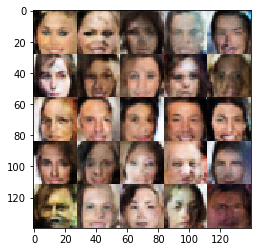

Epoch 1/1... Discriminator Loss: 1.2696... Generator Loss: 0.9187
Epoch 1/1... Discriminator Loss: 1.4562... Generator Loss: 0.6445
Epoch 1/1... Discriminator Loss: 1.4408... Generator Loss: 0.7222
Epoch 1/1... Discriminator Loss: 1.1937... Generator Loss: 0.9937
Epoch 1/1... Discriminator Loss: 1.4622... Generator Loss: 1.2815
Epoch 1/1... Discriminator Loss: 1.3764... Generator Loss: 0.7972
Epoch 1/1... Discriminator Loss: 1.4013... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3424... Generator Loss: 0.8266
Epoch 1/1... Discriminator Loss: 1.5383... Generator Loss: 0.5612
Epoch 1/1... Discriminator Loss: 1.5041... Generator Loss: 0.5961
out_channel_dim 3


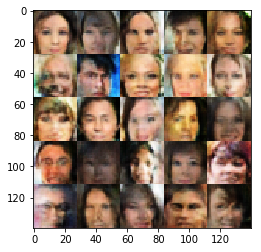

Epoch 1/1... Discriminator Loss: 1.4197... Generator Loss: 0.6947
Epoch 1/1... Discriminator Loss: 1.3205... Generator Loss: 0.7945
Epoch 1/1... Discriminator Loss: 1.5090... Generator Loss: 0.5900
Epoch 1/1... Discriminator Loss: 1.5674... Generator Loss: 0.7657
Epoch 1/1... Discriminator Loss: 1.3033... Generator Loss: 0.7693
Epoch 1/1... Discriminator Loss: 1.2460... Generator Loss: 0.8047
Epoch 1/1... Discriminator Loss: 1.4087... Generator Loss: 0.6763
Epoch 1/1... Discriminator Loss: 1.5493... Generator Loss: 0.4813
Epoch 1/1... Discriminator Loss: 1.4843... Generator Loss: 0.5039
Epoch 1/1... Discriminator Loss: 1.3720... Generator Loss: 0.7178
out_channel_dim 3


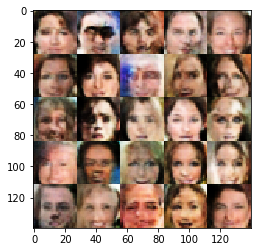

Epoch 1/1... Discriminator Loss: 1.4837... Generator Loss: 0.6278
Epoch 1/1... Discriminator Loss: 1.4040... Generator Loss: 0.7077
Epoch 1/1... Discriminator Loss: 1.4646... Generator Loss: 0.7493
Epoch 1/1... Discriminator Loss: 1.1777... Generator Loss: 1.0887
Epoch 1/1... Discriminator Loss: 1.3853... Generator Loss: 0.6732
Epoch 1/1... Discriminator Loss: 1.3971... Generator Loss: 0.8111
Epoch 1/1... Discriminator Loss: 1.4440... Generator Loss: 0.6807
Epoch 1/1... Discriminator Loss: 1.3473... Generator Loss: 0.6564
Epoch 1/1... Discriminator Loss: 1.4677... Generator Loss: 0.5247
Epoch 1/1... Discriminator Loss: 1.4186... Generator Loss: 0.6403
out_channel_dim 3


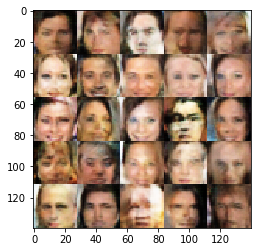

Epoch 1/1... Discriminator Loss: 1.4284... Generator Loss: 0.6969
Epoch 1/1... Discriminator Loss: 1.3146... Generator Loss: 0.8576
Epoch 1/1... Discriminator Loss: 1.4320... Generator Loss: 0.9985


In [13]:
batch_size = 32
z_dim = 100
learning_rate = 0.0003
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.